In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stt
import numpy as np
import os

In [3]:
# parameters
cwd = os.getcwd()  # current working directory
ROOT = os.path.dirname(os.path.dirname(cwd))  # root directory

data_raw_file_name = "data_raw"  # folder with raw data
data_raw_path = os.path.join(ROOT, data_raw_file_name)  # path of this folder

subject = "CATS-17-MC"  # ID of the subject (?!)

In [4]:
fr = np.load(os.path.join(data_raw_path, f"{subject}-fr.npy"))
theta = np.load(os.path.join(data_raw_path, f"{subject}-labels.npy"))

peri_stim_time = np.linspace(-0.1, 0.5, 61)
print(fr.shape, theta.shape)
print(f"(variable, time, trial, neuron), (variable, trial)")
print(f"possible theta : {np.unique(theta)}")

(8, 61, 360, 249) (8, 360)
(variable, time, trial, neuron), (variable, trial)
possible theta : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


This dataset has been recorded in the cat visual area number $17$. Our stimulus is an 2D motion presented during $0.3$ s with a particular orientation ($\theta$) and a particular precision level ($B_\theta$, variable). In the dataset, we divided our trials for each precision level ($8$) and the recordings give us the firing rate of $249$ neurons over $61$ time steps.

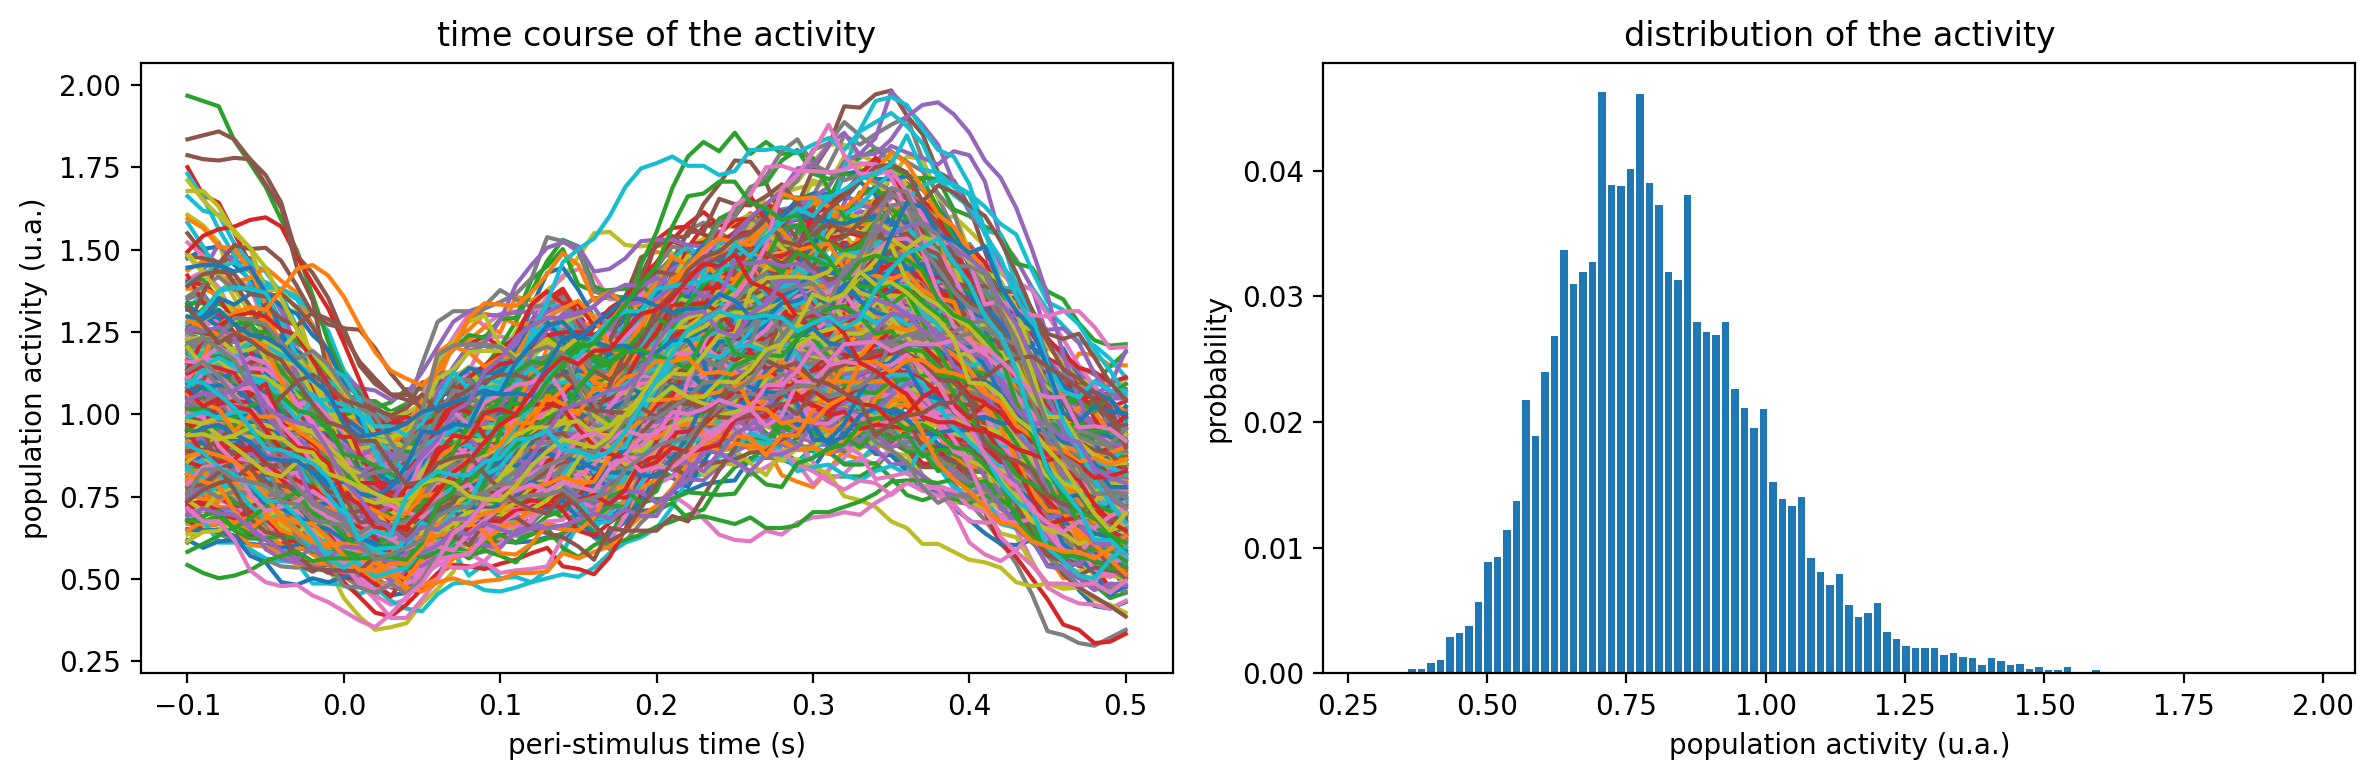

In [5]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12,4),
    dpi=200
)

ax[0].plot(
    peri_stim_time,
    fr[-1,:,:,:].mean(axis=-1)
)
ax[0].set_ylabel(
    "population activity (u.a.)"
)
ax[0].set_xlabel(
    "peri-stimulus time (s)"
)
ax[0].set_title(
    "time course of the activity"
)


values, bins = np.histogram(
    fr[0,:,:,:].mean(axis=-1),
    bins=np.linspace(
        fr[-1,:,:,:].mean(axis=-1).min(),
        fr[-1,:,:,:].mean(axis=-1).max(),
        100
    )
)
ax[1].bar(
    bins[:-1],
    values / values.sum(),
    width=(bins[1] - bins[0]) * 0.8
)
ax[1].set_xlabel(
    "population activity (u.a.)"
)
ax[1].set_ylabel(
    "probability"
)
ax[1].set_title(
    "distribution of the activity"
)

plt.tight_layout()
plt.show()

We can try to represent the activity of one neuron for each possible theta value.

In [6]:
neuron = 0

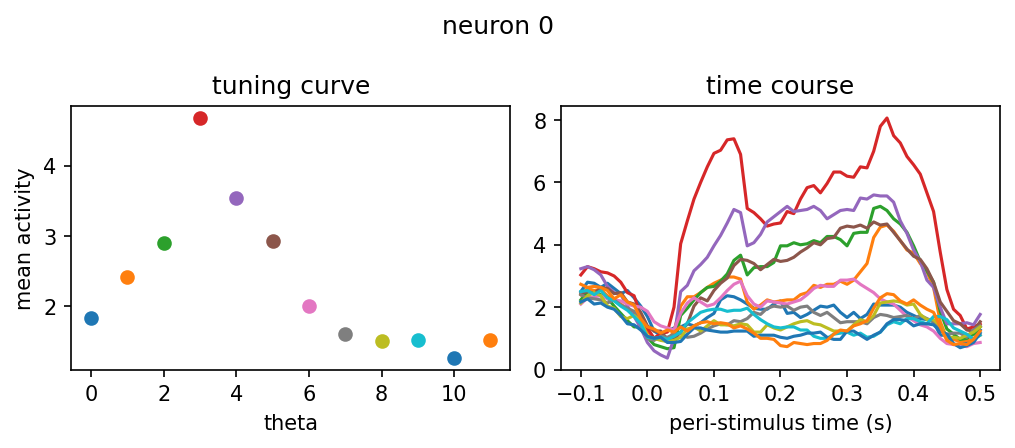

In [7]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(7,3),
    dpi=150
)


for th in np.sort(np.unique(theta)):

    index_th = np.where(theta[-1,:] == th)[0]

    ax[0].scatter(
        th,
        fr[-1, :, index_th, neuron].mean()
    )

    ax[1].plot(
        peri_stim_time,
        fr[-1, :, index_th, neuron].mean(axis=0)
    )

ax[0].set_xlabel("theta")
ax[0].set_ylabel("mean activity")
ax[1].set_xlabel("peri-stimulus time (s)")

ax[0].set_title("tuning curve")
ax[1].set_title("time course")

fig.suptitle(f"neuron {neuron}")

plt.tight_layout()
plt.show()

We can try to explore the influence of the precision level on this tuning curve.

In [8]:
neuron = 0

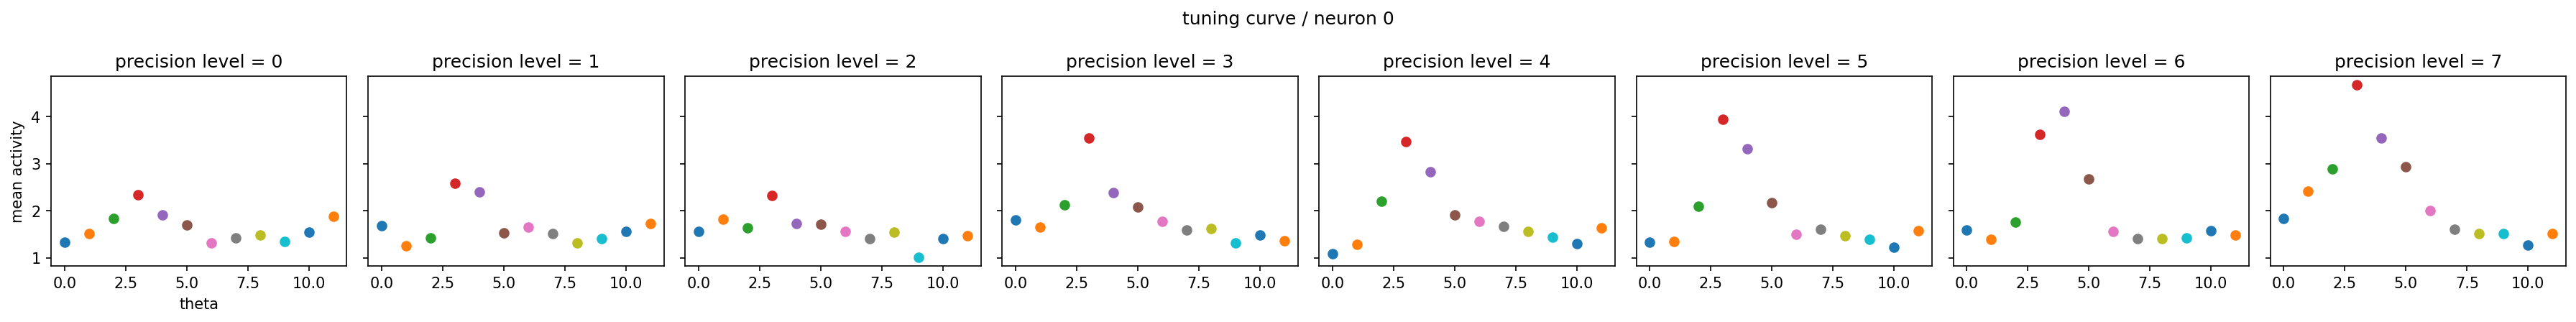

In [9]:
fig, ax = plt.subplots(
    nrows=1, ncols=fr.shape[0],
    figsize=(3*fr.shape[0],3),
    sharey=True,
    dpi=150
)

for bth in range(fr.shape[0]):

    for th in np.sort(np.unique(theta)):

        index_th = np.where(theta[bth,:] == th)[0]

        ax[bth].scatter(
            th,
            fr[bth, :, index_th, neuron].mean()
        )

    ax[bth].set_title(f"precision level = {bth}")

ax[0].set_xlabel("theta")
ax[0].set_ylabel("mean activity")

fig.suptitle(f"tuning curve / neuron {neuron}")

plt.tight_layout()
plt.show()

To conclude, we can explore the influence of the level of precision on the tuning curve using a metric called the circular variance.

In [10]:
circular_variance = np.ones((fr.shape[0], fr.shape[-1]))

for neuron in range(fr.shape[-1]):

    for bth in range(fr.shape[0]):

        data = []

        for th in np.sort(np.unique(theta)):

            index_th = np.where(theta[bth,:] == th)[0]

            data.append(fr[bth, :, index_th, neuron].mean())
        
        circular_variance[bth, neuron] = stt.circvar(data)

In [41]:
from sklearn.linear_model import LinearRegression

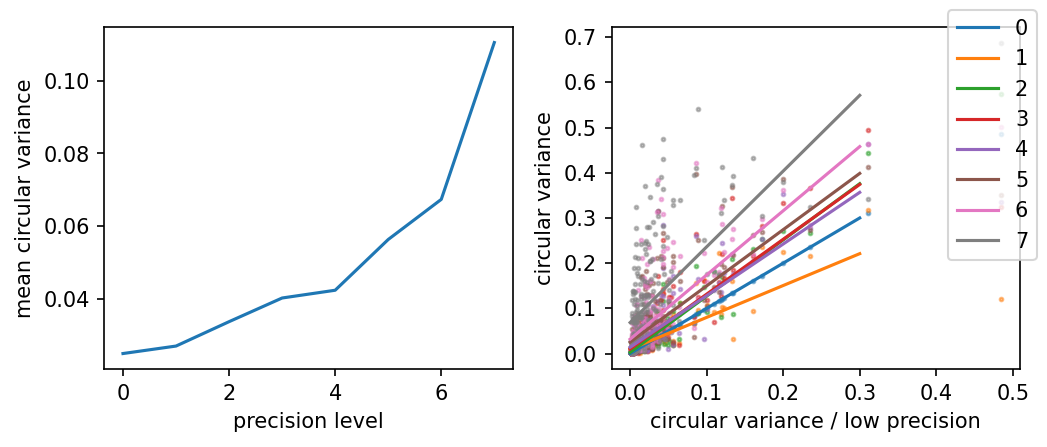

In [45]:
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(7,3),
    dpi=150
)

ax[0].plot(
    circular_variance.mean(axis=1),
)

for i in range(circular_variance.shape[0]):
    
    ax[1].scatter(
        circular_variance[0,:],
        circular_variance[i,:],
        s=3, alpha=0.5
    )

    linearreg = LinearRegression().fit(
        circular_variance[0,:].reshape(-1, 1),
        circular_variance[i,:].reshape(-1, 1)
    )
    ax[1].plot(
        np.linspace(0, 0.3, 100),
        linearreg.coef_.item() * np.linspace(0, 0.3, 100) + linearreg.intercept_.item(),
        label=i
    )

fig.legend()
ax[0].set_xlabel("precision level")
ax[0].set_ylabel("mean circular variance")

ax[1].set_xlabel("circular variance / low precision")
ax[1].set_ylabel("circular variance")

plt.tight_layout()
plt.show()